# `xarray` exercises pt 2: ENSO Analysis

Welcome, this is a the second part on xarray. In it, we will use data from  [Pangeo-Forge](https://pangeo-forge.org/).
[Pangeo](https://pangeo.io/) is a community platform for big data geoscience. We will use cloud-hosted datasets of global precipitation and sea surface temperatures to investigate the role of ENSO in monsoon precipitation in both Asia and the Southwest US.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

# Pulling in our data
We will pull in precipitation data from [NOAA Daily Global Precipitation data](https://www.ncei.noaa.gov/products/climate-data-records/precipitation-gpcp-daily) and sea surface temperature data from the [Hadley Centre Global Sea Ice and Sea Surface Temperature](https://climatedataguide.ucar.edu/climate-data/sst-data-hadisst-v11). 

To access the data all we need to do is put in the url to the dataset on Pangeo Forge. That can just get passed into xarray and we are good to go. Note this dataset is about 3.0 GB, and the file opens basically instantly. This is because xarray is lazy and only opens the metadata. Data will only be pulled in over the network when we actually do something with it.

In [3]:
gpm_file = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/gpcp-feedstock/gpcp.zarr'
gpm = xr.open_dataset(gpm_file, engine='zarr', chunks={})
gpm = gpm['precip']

sst_file = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/HadISST-feedstock/hadisst.zarr'
sst = xr.open_dataset(sst_file, engine='zarr', chunks={})
sst = sst['sst']
gpm

<xarray.DataArray 'precip' (time: 9226, latitude: 180, longitude: 360)> Size: 2GB
dask.array<open_dataset-precip, shape=(9226, 180, 360), dtype=float32, chunksize=(200, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time       (time) datetime64[ns] 74kB 1996-10-01 1996-10-02 ... 2021-12-31
Attributes:
    cell_methods:   area: mean time: mean
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [0.0, 100.0]

# Step 1: Plotting seasonal average precipitations

## Part 1
Let's begin by familiarizing ourselves with the precipitation data. To do so, let's compute the seasonal average precipitation across the globe for the period of record (aka all times in the dataset).

Your goal here is to group the `gpm` data by the `gpm['time'].dt.season` and compute the mean over the `time` dimension. The resulting dimensions of the new dataset should be `(season, latitude, longitude)`.

In [4]:
seasonal_precip = gpm.groupby(gpm['time'].dt.season).mean()
seasonal_precip

<xarray.DataArray 'precip' (season: 4, latitude: 180, longitude: 360)> Size: 1MB
dask.array<stack, shape=(4, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float32 1kB 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * season     (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    cell_methods:   area: mean time: mean
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [0.0, 100.0]

## Part 2

Now that you've got your dataset aggregated, let's make a plot of what's in it. For this one, we'll use `xarray`'s built in plotting capability to make things easy. Call `.plot` on the `seasonal_precip` DataArray. Use the following arguments to make your plot nicer:
 * `col='season'`: Each season will be as separate column
 * `col_wrap=2` : Wrap over to a new row after 2 columns. This makes the plot a 2x2 grid of subplots
 * `cmap='turbo'`: Use the "turbo" colormap.
 
Note 1: This will take a minute or two to complete, remember we're actually working with gigabytes of data.

Note 2: The `with ProgressBar()` outer bit makes it so that we track how var in the computation things are. This should slowly tick up so that you can ensure things are happening. This is special to `dask` and cloud datasets.

[                                        ] | 0% Completed | 236.88 us

[########################################] | 100% Completed | 18.04 s


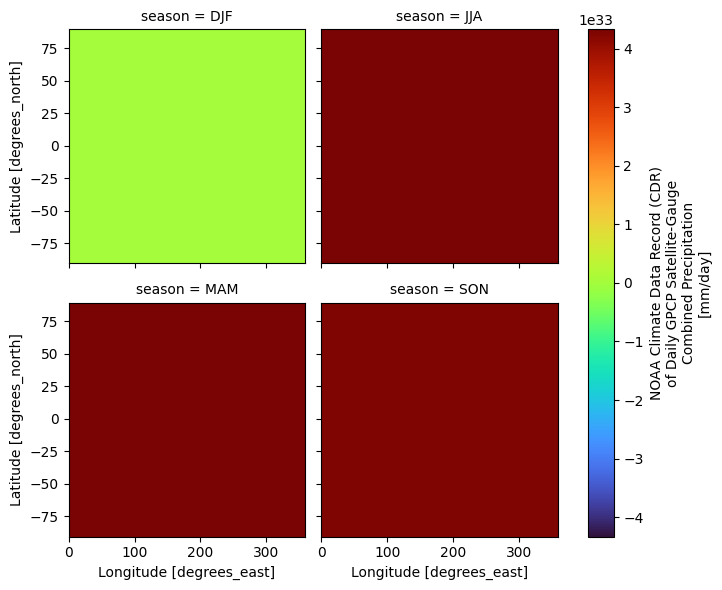

In [5]:
with ProgressBar():
    seasonal_precip.plot(col='season', col_wrap=2, cmap='turbo')

## Part 3:

Hey! That looks like garbage!? Often times you'll need to do some data cleanup before you can run your analysis, as "bad values" can ruin everything like we've seen above. To fix things, let's create a `mask` variable which we will use to filter out really large values. Specifically, we want to select data when `gpm['precip'] < 1000.0` and where `gpm['precip'] > 0`. You can join logical statements with the `&` operator, just like using `+` to add two arithmetic operations. Your only task here is to create the mask variable. 

[########################################] | 100% Completed | 15.85 s


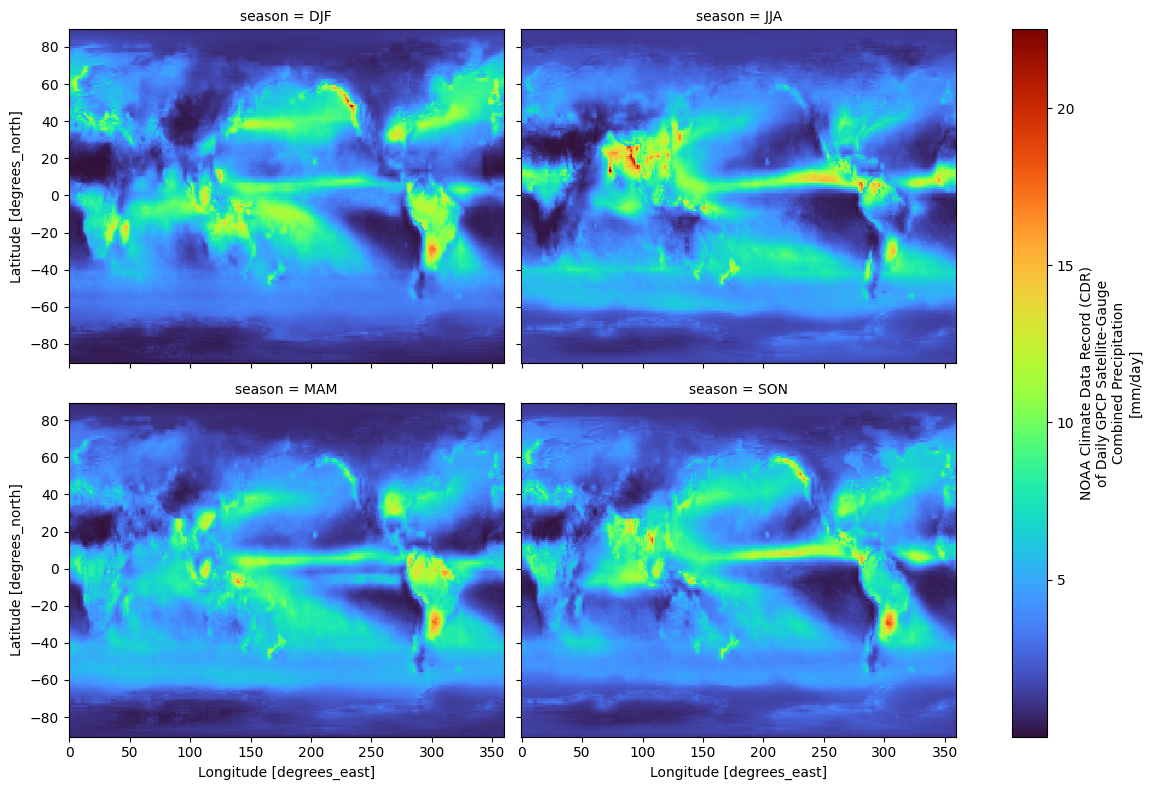

In [6]:
with ProgressBar():
    low_condition = gpm > 0
    high_condition = gpm < 1000.0
    mask = low_condition & high_condition
    seasonal_precip = (gpm.where(mask)
                          .groupby(gpm['time'].dt.season)
                          .mean(dim='time')
                          .compute())

seasonal_precip.plot(col='season', col_wrap=2, cmap='turbo', figsize=(12, 8))

## Part 4:
The plot from part 3 should now be a lot more interesting. Describe briefly what you're seeing below.


#### Your response below:
TODO

I'm seeing a map of the earth showing the areas of high and low precipitation over the seasons DJF, JJA, MAM, and SON

# Step 2: Calculating an ENSO index

We don't have nearly enough time to get into the science, but briefly the El-Niño Southern Oscillation (ENSO) is a phenomena of periodic changes in the sea surface temperature and wind patterns in the eastern equatorial Pacific Ocean. This oscillation has strong impacts on many aspects of the climate system, including monsoonal precipitation patterns. The figure below shows a timeseries of sea surface temperature anomalies for this region. The dotted points are the actual data, black line is a smoothed average, and the shaded blue/red regions show prolonged deviations from the mean. We will first re-create a similar plot to this.

![image.png](https://upload.wikimedia.org/wikipedia/commons/0/02/Soi.svg)

To get from the global SST dataset to a timeseries of anomalies we will need 4 parts. 

  1) First, select out the latitude range of $(+5, -5)$ and the longitude range of $(-170, -150)$ degrees. Note the sign ordering.
  2) Take the mean of this resulting `nino_ext` DataArray over the `['latitude', 'longitude']` dimensions and assign this to `nino_sst`.
  3) Also calculating the mean over the `'time'` dimension from `nino_sst`. Assign this to `nino_mean`
  4) Finally, compute the `nino_anomalies` by subtracting the `nino_mean` from `nino_sst`
  
### Part 1:
First, select out the latitude range of $(+5, -5)$ and the longitude range of $(-170, -150)$ degrees. Note the sign ordering.

The resulting DataArray should have dimensions:     
 * latitude: 10 
 * longitude: 20
 * time: 1829

In [7]:
nino_lat = slice(+5.0, -5.0) #x-array by default thinks you're trying to index; you need to give it a slice
nino_lon = slice(-170, -150)
nino_extent = sst.sel(latitude=nino_lat, longitude=nino_lon)
nino_extent

<xarray.DataArray 'sst' (time: 1829, latitude: 10, longitude: 20)> Size: 1MB
dask.array<getitem, shape=(1829, 10, 20), dtype=float32, chunksize=(1829, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 40B 4.5 3.5 2.5 1.5 ... -1.5 -2.5 -3.5 -4.5
  * longitude  (longitude) float32 80B -169.5 -168.5 -167.5 ... -151.5 -150.5
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
Attributes:
    cell_methods:   time: lat: lon: mean
    long_name:      sst
    standard_name:  sea_surface_temperature
    units:          C

### Part 2:
Take the mean of this resulting `nino_ext` DataArray over the `['latitude', 'longitude']` dimensions and assign this to `nino_sst`.

The resulting DataArray should only have a time dimension

In [8]:
nino_sst = nino_extent.mean(dim=['latitude','longitude'])
nino_sst

<xarray.DataArray 'sst' (time: 1829)> Size: 7kB
dask.array<mean_agg-aggregate, shape=(1829,), dtype=float32, chunksize=(1829,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 202...

### Part 3:
Calculate the mean over the `'time'` dimension from `nino_sst`. Assign this to `nino_mean`

The resulting DataArray should have no dimensions, and a `shape` of `()`

In [9]:
nino_mean = nino_sst.mean(dim='time')
nino_mean

<xarray.DataArray 'sst' ()> Size: 4B
dask.array<mean_agg-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

###  Part 4:

Finally, compute the `nino_anomalies` by subtracting the `nino_mean` from `nino_sst`

The resulting DataArray should have dimensions of time only. Values should be both positive and negative. You can even check to ensure that the mean is close to 0


In [10]:
with ProgressBar():
    nino_anomalies = (nino_sst - nino_mean).compute()

nino_anomalies

[########################################] | 100% Completed | 3.94 ss


<xarray.DataArray 'sst' (time: 1829)> Size: 7kB
array([-1.0625896 , -1.6202965 , -1.0364552 , ..., -1.0277634 ,
       -0.63593674, -0.45277596], shape=(1829,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 202...

In [11]:
nino_anomalies.mean().round(2) == 0

<xarray.DataArray 'sst' ()> Size: 1B
array(True)

## Putting step 2 together

If you've made it this far you should be able to run the following code cell to create a plot like the one shown at the beginning of Step 2. The plot won't look exactly the same because we are using a different dataset, different region of aggregation, and different method of plotting the smoothed timeseries. But, you should be able to see a similarity in the ebb-and-flow of the ENSO signature that we're plotting below.

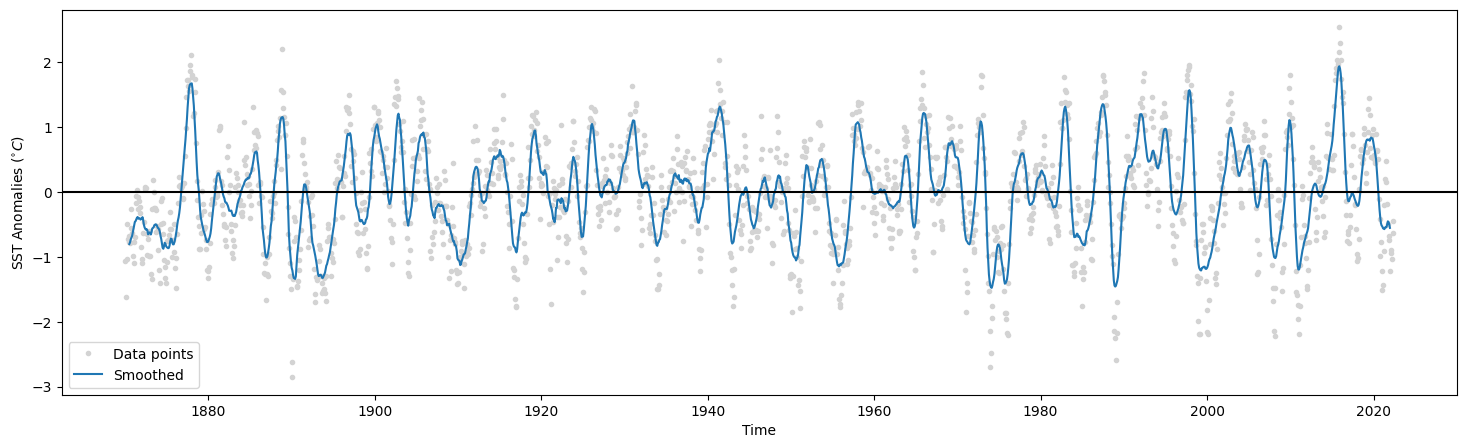

In [12]:
fig, ax = plt.subplots(1,1, figsize=(18, 5))
nino_anomalies.plot(marker='.', linestyle='', color='lightgrey', label='Data points')
nino_anomalies.rolling(time=12, center=True).mean().plot(label='Smoothed')
ax.axhline(0, color='black')
plt.ylabel(r'SST Anomalies ($^{\circ} C$)')
plt.legend()

## Step 3: Merging the SST and Precipitation datasets

One of the fundamental skills for doing science on large datasets is being able to match up their temporal/spatial resolutions to facilitate analysis. Our two datasets have different time extents, time resolutions, and spatial resolutions. To be able to merge them together we'll need to either reduce some of the data or match the spatiotemporal variablity. 

We've actually already taken care of one pieces of this by calculating the `nino_anomalies` in the previous step, which now simply has a `time` dimension at the monthly timescale. But there are still some loose ends. To clean them up you'll need to complete 3 parts:

1) Match up the time extents for the `gpm` and `nino_anomalies` datasets.
2) Match up the time stamps for the `gpm` and `nino_anomalies` datasets.
3) Re-apply the masking technique from earlier to filter out bad precipitation data.

### Part 1:

Find the first and last times in both the `gpm` and `nino_anomalies` datasets. These can be computed by calling the `min` and `max` functions on the "time" dimension of each dataset, respectively. This cell should print out a single time slice with times starting in 1996 and ending in 2021.

In [13]:
#looking at how does ENSO correlate to precipitation data around the world
first_gpm = gpm['time'].min() #can also use the isel(time=0) and isel(time=-1) methods    
last_gpm = gpm['time'].max() 

first_nino = nino_anomalies['time'].min()
last_nino = nino_anomalies['time'].max()

first_time = max(first_gpm, first_nino)
last_time = min(last_gpm, last_nino)
time_slice = slice(first_time, last_time)
time_slice

slice(<xarray.DataArray 'time' ()> Size: 8B
array('1996-10-01T00:00:00.000000000', dtype='datetime64[ns]'), <xarray.DataArray 'time' ()> Size: 8B
array('2021-12-31T00:00:00.000000000', dtype='datetime64[ns]'), None)

### Part 2:

Next, we'll need to align the timestamps so that they fit together. To do so, I've set you up to select out the correct time slice from the previous part but you'll need to do the `resample` to a monthly mean. This can be accomplished by calling the `resample` function with an argument which is a dictionary where the key is `'time'` and the `value` is `'1M'` (which means "one month"). Finally, after the call to resample you can compute the mean with the `mean` function. These `monthly_nino` and `monthly_gpm` variables should be able to be placed into the same dataset which has dims of `time`, `latitude`, and `longitude`.

In [14]:
monthly_nino = nino_anomalies.sel(time=time_slice)
monthly_gpm = gpm.sel(time=time_slice)

monthly_nino = monthly_nino.resample(time='1ME').mean( )
monthly_gpm = monthly_gpm.resample(time='1ME').mean( )

# Putting things into a new dataset with shared coordinates
ds = xr.Dataset()
ds['nino_anomalies'] = monthly_nino

ds['precip'] = monthly_gpm

ds

<xarray.Dataset> Size: 79MB
Dimensions:         (time: 303, latitude: 180, longitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 1996-10-31 ... 2021-12-31
  * latitude        (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * longitude       (longitude) float32 1kB 0.0 1.0 2.0 ... 357.0 358.0 359.0
Data variables:
    nino_anomalies  (time) float32 1kB -0.2171 -0.2259 -0.427 ... -0.741 -1.22
    precip          (time, latitude, longitude) float32 79MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

### Part 3:
Finally, you'll need to mask out the same precipitation data as you did in Step 1 Part 3. This should yield a plot which has some meaningful patterns. This might take some time to complete, so you should make sure that the first code cell completes with no errors before attempting to run the second one.

In [15]:
mask = (monthly_gpm > 0) & (monthly_gpm < 1000.0)
ds['precip'] = ds['precip'].where(mask, other=np.nan)
ds

<xarray.Dataset> Size: 79MB
Dimensions:         (time: 303, latitude: 180, longitude: 360)
Coordinates:
  * time            (time) datetime64[ns] 2kB 1996-10-31 ... 2021-12-31
  * latitude        (latitude) float32 720B -90.0 -89.0 -88.0 ... 87.0 88.0 89.0
  * longitude       (longitude) float32 1kB 0.0 1.0 2.0 ... 357.0 358.0 359.0
Data variables:
    nino_anomalies  (time) float32 1kB -0.2171 -0.2259 -0.427 ... -0.741 -1.22
    precip          (time, latitude, longitude) float32 79MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>

[########################################] | 100% Completed | 13.31 s


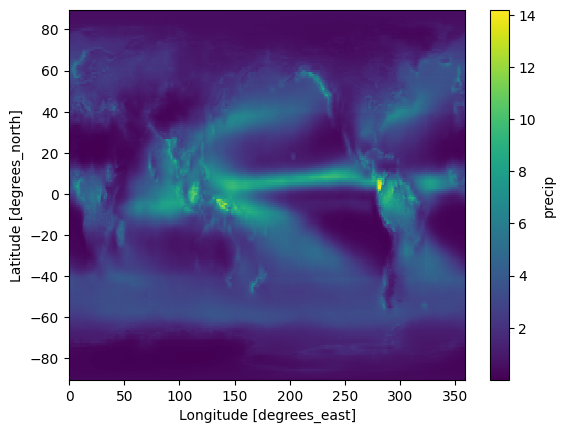

In [16]:
with ProgressBar():
    ds['precip'].mean(dim='time').plot()

# Step 4: How does the ENSO index correspond to precipitation?

We're finally to the end of this thing! Now that you've got your precipitation data and ENSO signature on the same timestamp and filtered only to meaningful data it's time to look at the correlations. We'll first look at this for a particular region around Indonesia and then for the global context.

This will happen in 4 parts. 
  1) First, select out the latitude range $(0, 10)$ and longitude with range $(100, 130)$, and take the spatial mean for the dataset `ds`.
  2) Once calculated, plot the two timeseries for the ENSO anomaly and precipitation on separate subplots.
  3) Make a scatter plot of the same variables. 
  4) Finally, calculate the global correlation between the ENSO signature and precipitation timeseries and plot the correlation as a map.

### Part 1

Here you should be familiar with using either the `range` or `slice` notation to set up the `sea_monsoon_lat` and `sea_monsoon_lon` variables. Just setting those up should be all you need to do, I've already put together the reduction to a spatial mean together for you inside of the `with ProgressBar()` clause. This will probably take a minute or two to run.

In [17]:
sea_monsoon_lat = slice(0, 10)
sea_monsoon_lon = slice(100, 130)
with ProgressBar():
    sea_monsoon_ppt = ds.sel(
        latitude=sea_monsoon_lat, 
        longitude=sea_monsoon_lon
    ).mean(dim=['latitude', 'longitude']).load()

[########################################] | 100% Completed | 13.08 s


### Part 2
With the data calculated you just have to put the right timeseries on the subplots. This should be reminiscent of the previous assignment where you had to make similar subplots. Just make sure that you're plotting both the `nino_anomalies` and `precip` variables on separate subplots and you should be good to go.

When looking at the resulting plots, do you see any correlation between the two? Feel free to write your observations below, though it's not necessary.

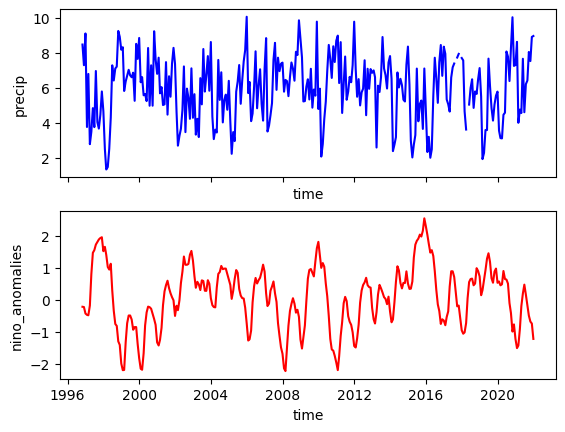

In [23]:
fig, axes = plt.subplots(2,1, sharex=True)
sea_monsoon_ppt['precip'].plot(ax=axes[0], color='blue')
sea_monsoon_ppt['nino_anomalies'].plot(ax=axes[1], color='red')

### Part 3

To confirm what you suspected from the previous plot let's also do a scatter plot of it all. All you need to do here is fill in the variable names for `x` and `y`.

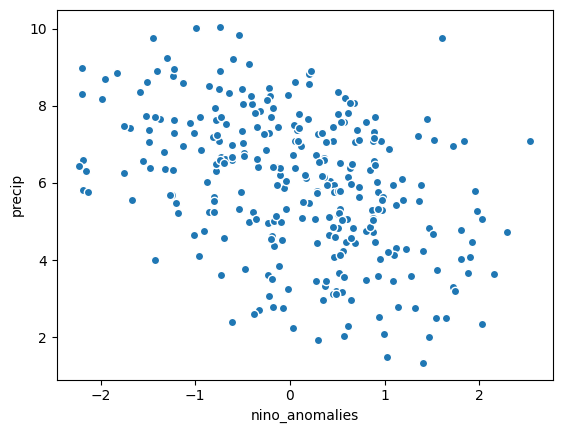

In [20]:
sea_monsoon_ppt.plot.scatter(
    x= 'nino_anomalies',
    y= 'precip',    
)

### Part 4
Finally, let's bring out the big moves and compute the correlation between these SST anomalies and precipitation amounts. To do so, use the `xr.corr` method like we did in the last assignment and plot the resulting correlations.


[########################################] | 100% Completed | 17.24 s


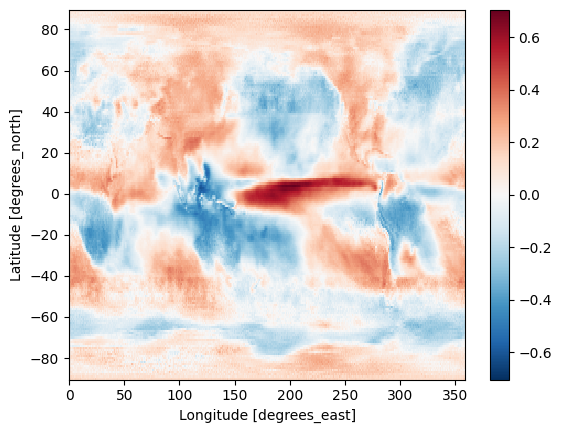

In [18]:
with ProgressBar():
    r_nino_precip =  xr.corr(
        ds['precip'],
        ds['nino_anomalies'],dim='time',
    ).compute()

r_nino_precip.plot()

# Reflections and next steps

Before we part ways, write a sentence or two about the final plot you made above. Where does ENSO matter? Do you think this tells the whole story?


In [ ]:
#There is a negative correlation of ENSO with precipitation in the Southeast Asia monsoon region, and high correlation in the ENSO region and in the southwest US